# Commodity Price Forecasting

## Source
The data comes from the [World Bank Commodity Price Data (The Pink Sheet)](https://www.bcsf.com.ar/ces/base-datos/preview/6/precios-internacionales-de-los-commodities).

## Coverage
Monthly prices in nominal US dollars, covering the period from **January 2010** to **May 2025**.

## Currency
All price series are reported in **nominal US dollars (USD)**.

## Variables Used

| Product  | Unit                         |
|----------|------------------------------|
| Soybeans | US Dollars per Metric Ton     |
| Wheat    | US Dollars per Metric Ton     |
| Meat     | US Dollars per Kilogram       |


## Usage
This dataset can be used for time series analysis, forecasting, and commodity price trend studies.

# Table of Contents

- [1. Introduction](#1-introduction)
- [2. Load and Visualizations](#2-carga-y-visualización-de-las-series)
- [3. Models and Evaluation](#3-modelado-y-evaluacion)
  - [3.1 SARIMAX model](#31-sarimax)
  - [3.2 XGBoost model](#32-xgboost)
  - [3.3 LSTM model](#33-lstm)
- [4. Final Model Comparison and Winner Selection](#5-comparación-final-de-modelos-y-selección-del-ganador)


## 1. Introduction

This analysis aims to forecast prices of agricultural commodities (trigo, carne y soja) by applying and comparing various time series models, including classical methods, neural networks, statistical models, and AutoML tools such as AutoTS.

## 2. Data Loading and Quality Checks
Historical monthly prices were loaded from an CSV file. The first rows of the dataset were inspected to verify proper loading.  
No additional data cleaning was required as the columns were found to be in good condition and complete.

In [8]:
import pandas as pd
import sys
sys.path.insert(0, './src/')
import importlib
import eda
import read_data
importlib.reload(read_data)
importlib.reload(eda)
from read_data import load_dataset, load_commodity
from eda import plot_time_series_resamples
from eda import check_series_validity



In [9]:
df = load_dataset()
df.head()

,Carne Vacuna,Trigo,Soja,Energy,Maiz,Oro,Metal Index
Date,,,,,,,
2010-01-01,3.02,201.19,435.88,98.50,167.31,1117.96,90.86
2010-02-01,3.21,194.00,411.86,95.60,161.80,1095.41,87.59
2010-03-01,3.40,191.08,409.36,99.58,159.05,1113.34,90.05
2010-04-01,3.66,192.87,402.60,104.85,157.08,1148.69,93.42
2010-05-01,3.58,181.61,402.87,95.68,163.38,1205.43,97.19


In [158]:
df_carne = load_commodity('Carne Vacuna')
df_trigo = load_commodity('Trigo')
df_soja = load_commodity('Soja')

### Check Series Validity 

In [180]:
check_series_validity(df_carne)

(True, [])

In [181]:
check_series_validity(df_trigo)

(True, [])

In [182]:
check_series_validity(df_soja)

(True, [])

### Visualizations

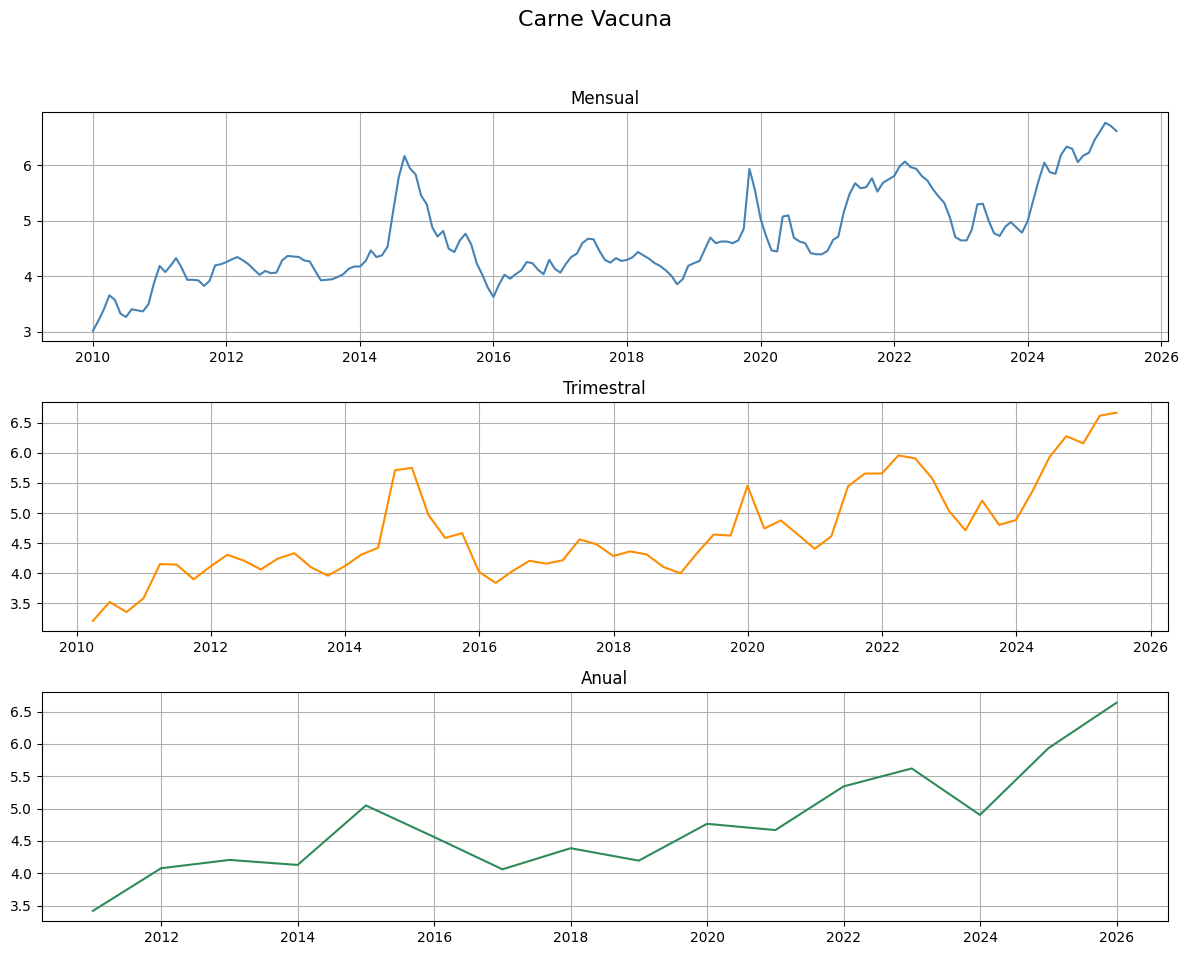

In [131]:
plot_time_series_resamples(df_carne, title='Carne Vacuna')

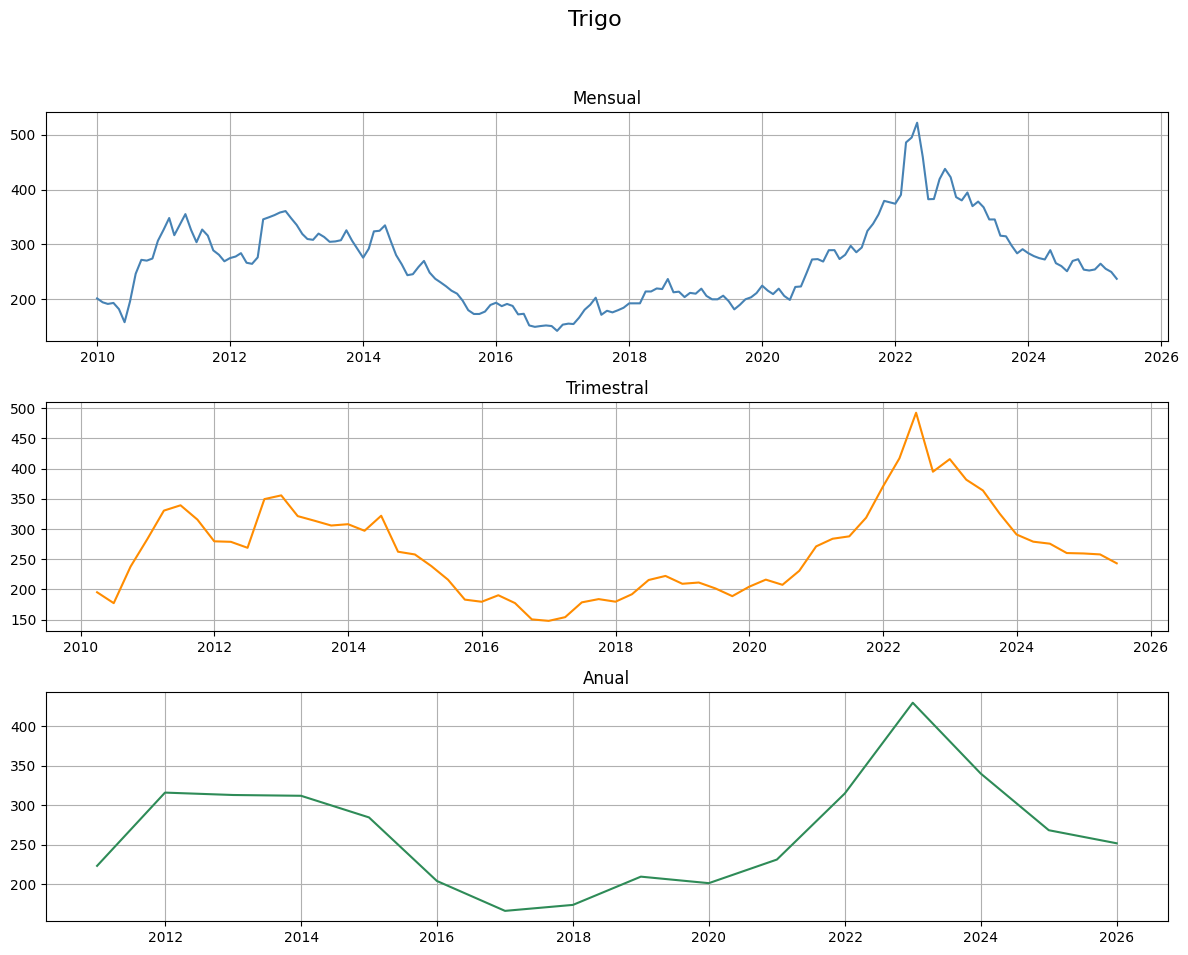

In [133]:
plot_time_series_resamples(df_trigo, title='Trigo')

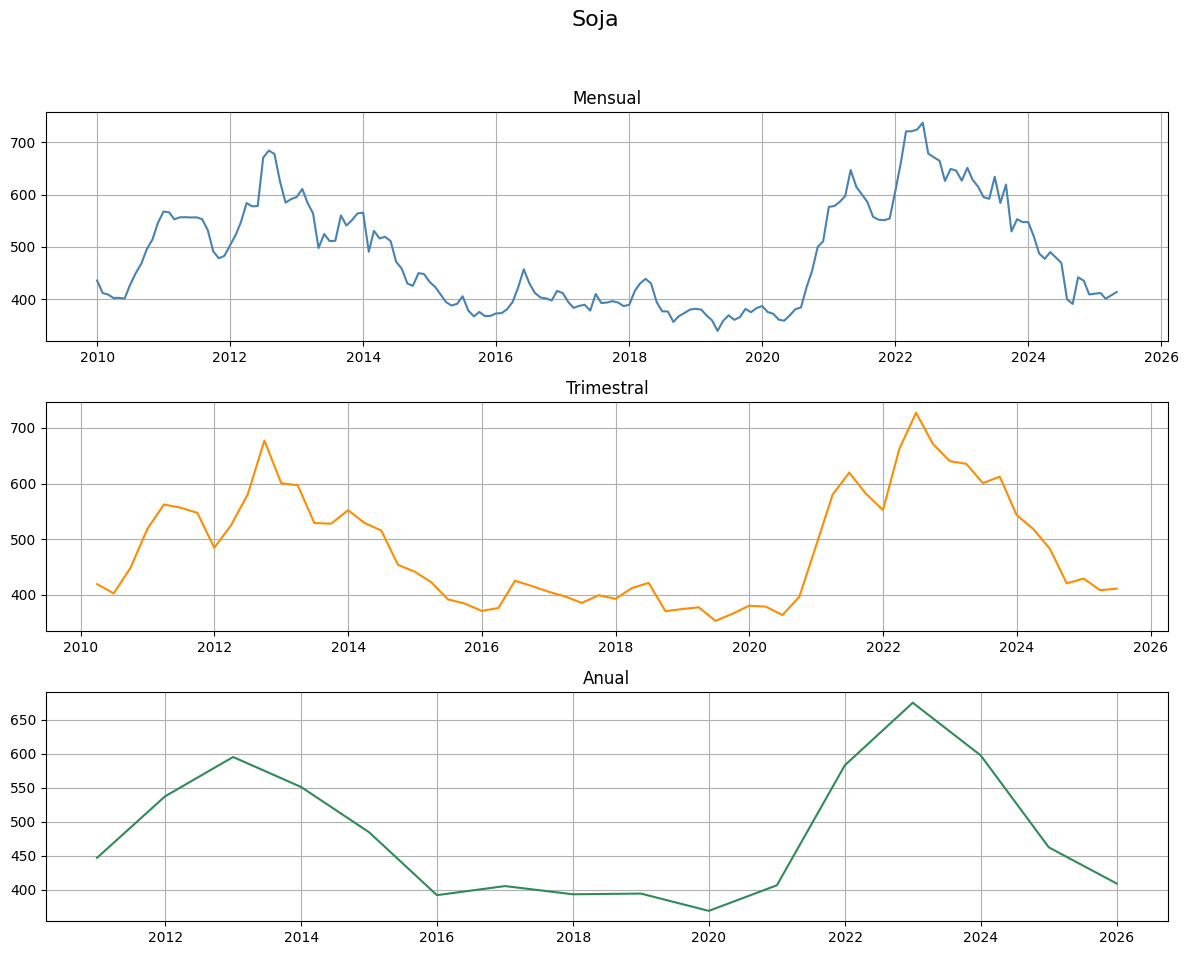

In [135]:
plot_time_series_resamples(df_soja, title='Soja')

## 3. Models and Evaluations

### 3.1 SARIMAX

In [13]:
from model_sarimax import ARIMAPipeline
import numpy as np
import joblib

MAE test: 0.62
RMSE test: 0.76
MAPE test: 12.13%
---
MAE train: 0.15
RMSE train: 0.21
MAPE train: 3.31%


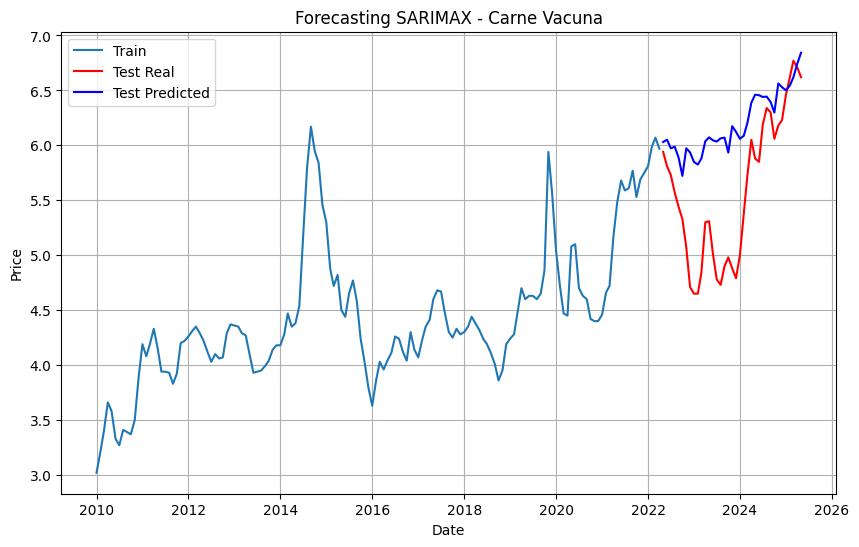

MAE test: 59.93
RMSE test: 80.52
MAPE test: 13.15%
---
MAE train: 71.06
RMSE train: 467.73
MAPE train: 13.59%


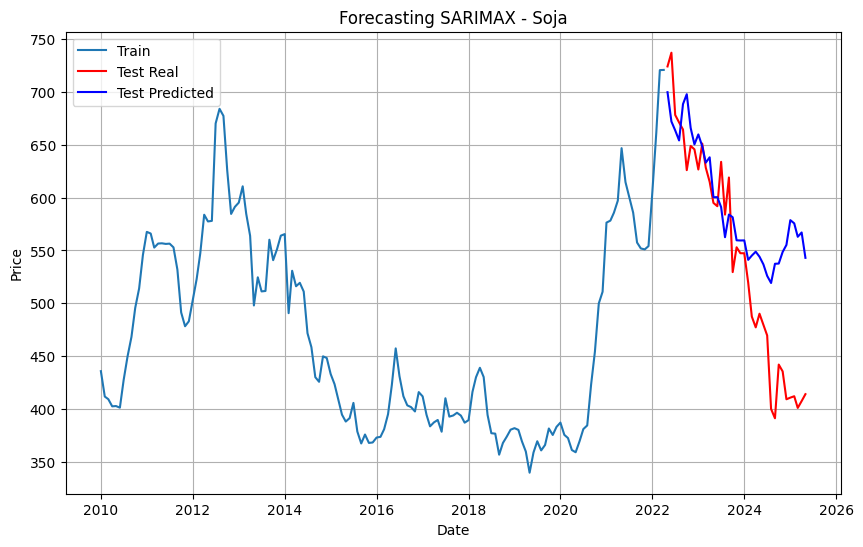

MAE test: 66.56
RMSE test: 74.84
MAPE test: 23.20%
---
MAE train: 14.32
RMSE train: 23.14
MAPE train: 5.59%


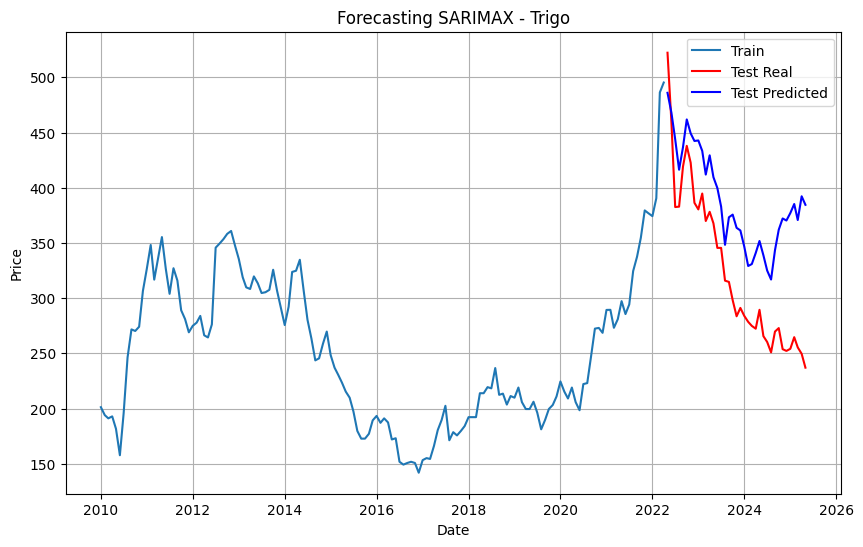

In [14]:
df = load_dataset()

commodity = ['Carne Vacuna', 'Soja', 'Trigo']
orders = [(0,1,1), (2,1,2), (1,1,1)]
seasonal_orders = [(0,1,1,12), (0,1,2,12), (1,1,1,12)]

exog_carne = pd.DataFrame(index=df.index)
exog_carne['log_energia'] = np.log(df['Energy'])
exog_carne['log_oro'] = np.log(df['Oro'])

exog_soja = pd.DataFrame(index=df.index)
exog_soja['log_maiz'] = np.log(df['Maiz'])
exog_soja['log_energia'] = np.log(df['Energy'])
exog_soja['log_trigo'] = np.log(df['Trigo'])
exog_soja['log_metal'] = np.log(df['Metal Index'])

exog_trigo = pd.DataFrame(index=df.index)
exog_trigo['log_maiz'] = np.log(df['Maiz'])
exog_trigo['log_energia'] = np.log(df['Energy'])
exog_trigo['log_soja'] = np.log(df['Soja'])
exog_trigo['log_metal'] = np.log(df['Metal Index'])

exogs = [exog_carne, exog_soja, exog_trigo]

for i, com in enumerate(commodity):
    train_size = int(len(df[com]) * 0.8)
    train = df[com].iloc[:train_size]
    test = df[com].iloc[train_size:]
    
    # Train
    pipe_arima = ARIMAPipeline(order=orders[i], seasonal_order=seasonal_orders[i])
    model = pipe_arima.fit(train, exogs[i].iloc[:train_size])

    # Save Model
    joblib.dump(model, f"{com.strip()}_model_sarimax_pipeline.pkl")

    # Predict
    pred_test = model.predict(test, exogs[i].iloc[train_size:])

    # Reports
    model.report()

    # Plots
    model.plot_predictions(title=f'Forecasting SARIMAX - {com}')


### 3.2 XGBoost

In [5]:
import matplotlib.pyplot as plt
from model_xgboost import XGBoostPipeline
import joblib


In [3]:
def create_features(df, target_col, lags=[1], add_month_dummies=True):
    df_feat = pd.DataFrame(index=df.index)
    df_feat[target_col] = df[target_col]
    
    # Lags
    for lag in lags:
        df_feat[f'lag_{lag}'] = df[target_col].shift(lag)
    
    df_feat['lag_12']=df[target_col].shift(12)
    df_feat['diff_seas'] = df[target_col] - df[target_col].shift(12)
    df_feat['diff_price'] = df[target_col] - df[target_col].shift(1)
    
    # Estacionalidad 
    if add_month_dummies:
        df_feat['month'] = df.index.month
        df_feat = pd.get_dummies(df_feat, columns=['month'], drop_first=True)
        df_feat.astype(float)
    return df_feat.dropna()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE_test: 0.28
RMSE_test: 0.38
MAPE_test: 4.47%
----
MAE_train: 0.04
RMSE_train: 0.06
MAPE_train: 0.88%


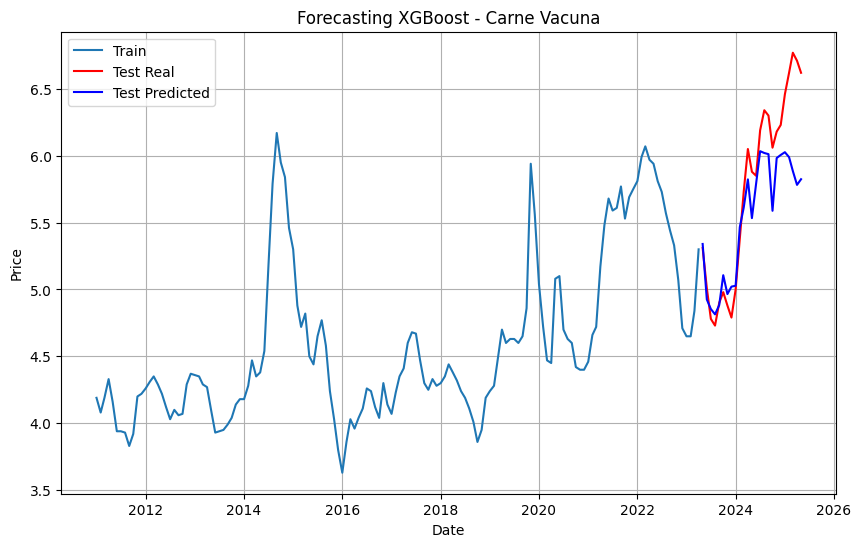

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE_test: 10.58
RMSE_test: 14.49
MAPE_test: 2.23%
----
MAE_train: 2.59
RMSE_train: 3.23
MAPE_train: 0.55%


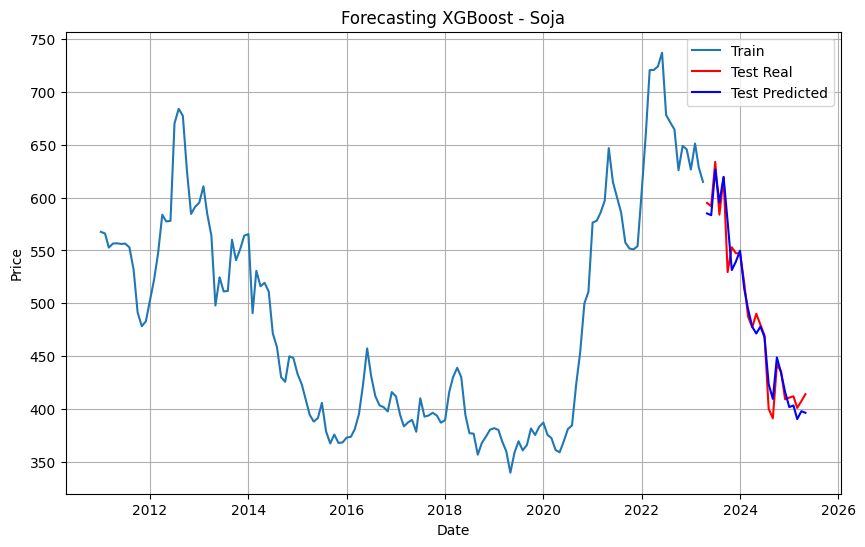

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE_test: 3.60
RMSE_test: 4.52
MAPE_test: 1.24%
----
MAE_train: 0.87
RMSE_train: 1.20
MAPE_train: 0.35%


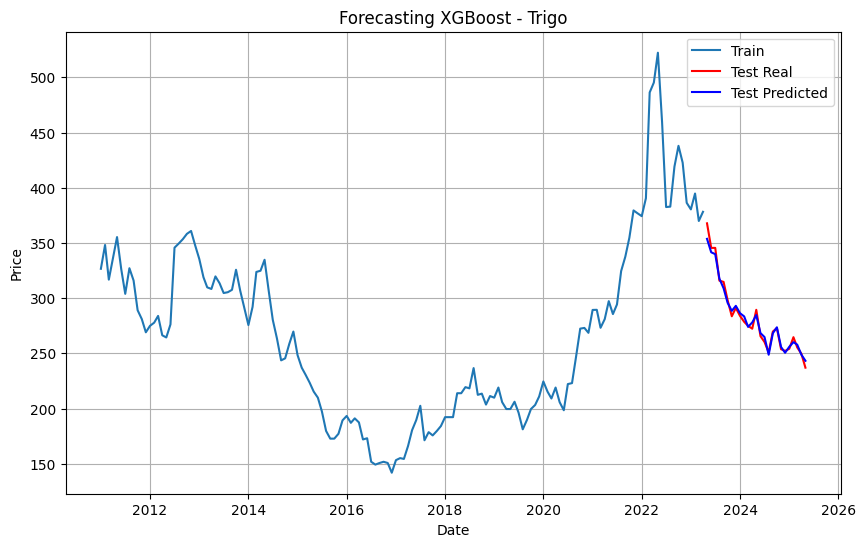

In [6]:
df = load_dataset()

train_size = int(len(df) * 0.8)
commodity = ['Carne Vacuna', 'Soja', 'Trigo']

for i, com in enumerate(commodity):
    df_feat = create_features(df, com, lags=[1])
    train = df_feat.iloc[:train_size]
    test = df_feat.iloc[train_size:]

    # Train
    pipe_XGB= XGBoostPipeline()
    model = pipe_XGB.fit(train, com)

    # Save Model
    joblib.dump(model, f"{com.strip()}_model_XGBoost_pipeline.pkl")

    # Predict
    pred_test = model.predict(test, com)

    # Reports
    model.report()

    # Plots
    model.plot_predictions(title=f'Forecasting XGBoost - {com}')


### 3.3 LSTM

In [2]:
import matplotlib.pyplot as plt
import joblib
from model_lstm import LSTMPipeline


In [3]:
def create_features(df, target_col, lags):
        df_feat = pd.DataFrame(index=df.index)
        df_feat[target_col] = df[target_col]
        for lag in lags:
            df_feat[f'lag_{lag}'] = df[target_col].shift(lag)
        df_feat['lag_12'] = df[target_col].shift(12)
        df_feat['diff_seas'] = df[target_col] - df[target_col].shift(12)
        df_feat['diff_price'] = df[target_col] - df[target_col].shift(1)
        df_feat = df_feat.dropna()
        return df_feat

5/5 [==============================] - 1s 5ms/step


INFO:tensorflow:Assets written to: ram://e49d86c7-b560-438c-b87e-7d6a3d3eb712/assets


INFO:tensorflow:Assets written to: ram://e49d86c7-b560-438c-b87e-7d6a3d3eb712/assets


1/1 [==============================] - 0s 33ms/step
MAE_test: 0.06
RMSE_test: 0.07
MAPE_test: 0.98%
----
MAE_train: 0.07
RMSE_train: 0.09
MAPE_train: 1.49%


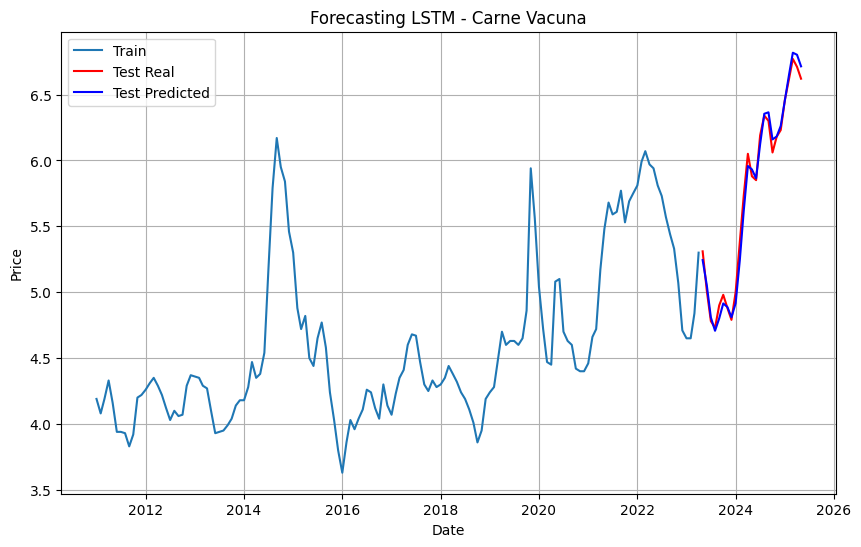

5/5 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: ram://54bb9795-267d-495a-8d61-0014af488f74/assets


INFO:tensorflow:Assets written to: ram://54bb9795-267d-495a-8d61-0014af488f74/assets


1/1 [==============================] - 0s 42ms/step
MAE_test: 7.73
RMSE_test: 10.32
MAPE_test: 1.62%
----
MAE_train: 7.84
RMSE_train: 9.49
MAPE_train: 1.71%


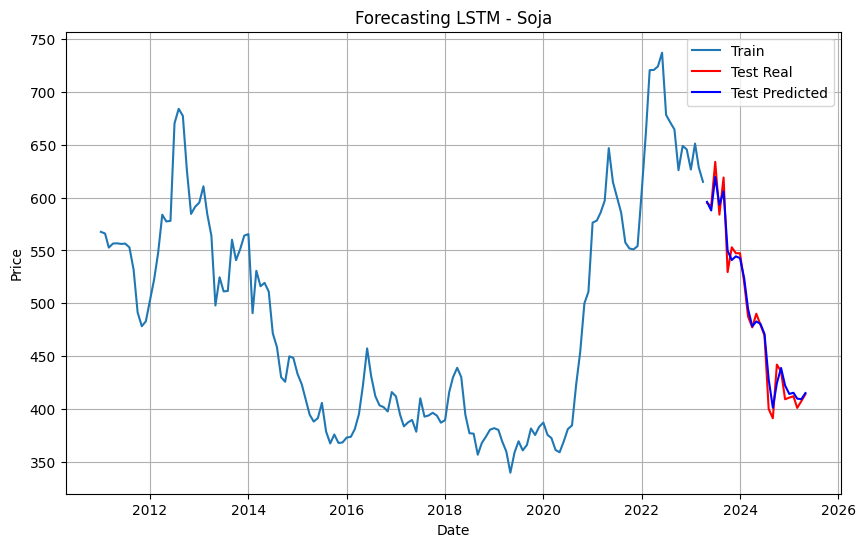

5/5 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: ram://002b632a-ea1e-4e64-bfc8-0b7f9993c9c4/assets


INFO:tensorflow:Assets written to: ram://002b632a-ea1e-4e64-bfc8-0b7f9993c9c4/assets


1/1 [==============================] - 0s 38ms/step
MAE_test: 4.96
RMSE_test: 6.14
MAPE_test: 1.75%
----
MAE_train: 6.52
RMSE_train: 8.71
MAPE_train: 2.54%


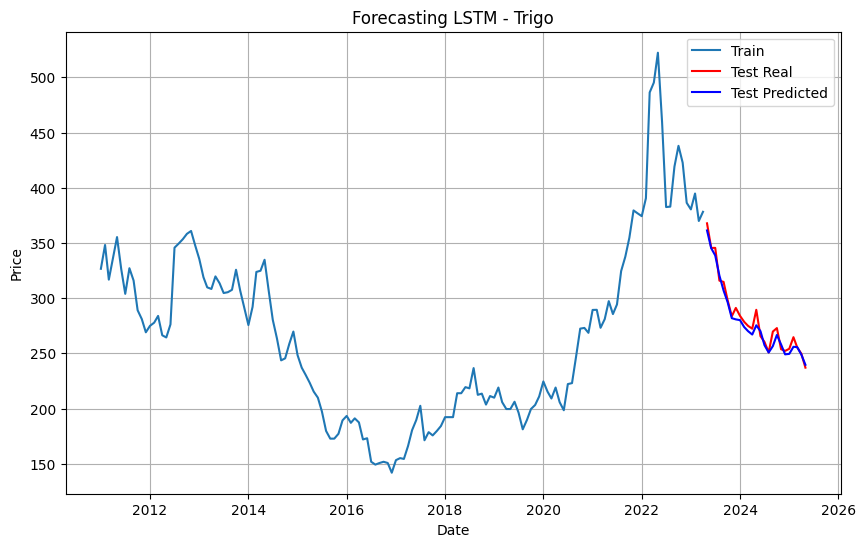

In [4]:
df = load_dataset()

train_size = int(len(df) * 0.8)
commodity = ['Carne Vacuna', 'Soja', 'Trigo']

for i, com in enumerate(commodity):
    df_feat = create_features(df, com, lags=[1])
    train = df_feat.iloc[:train_size]
    test = df_feat.iloc[train_size:]
    
    # Train
    pipe_LSTM = LSTMPipeline()
    model = pipe_LSTM.fit(train, com)

    # Save Model
    joblib.dump(model, f"{com.strip()}_model_LSTM_pipeline.pkl")

    # Predict
    pred_test = model.predict(test, com)

    # Reports
    model.report()

    # Plots
    model.plot_predictions(title=f'Forecasting LSTM - {com}')
